# Autonomous Vehicles Animal Detection 

In [2]:
import eda_batch
from logo import logo
import tarfile
import os
import numpy as np
from PIL import Image
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
from tensorflow.keras.initializers import RandomNormal

import plotly.graph_objects as go
from sklearn.model_selection import StratifiedKFold

In [3]:
from tensorflow.keras.datasets.cifar10 import load_data

(x_train, y_train), (x_test, y_test) = load_data()

In [2]:
logo()

# EDA

Try printing an image

In [4]:
labels = ['airplane','automobile','bird','cat','deer','dog',\
          'frog','horse','ship','truck']

Image label frog


C:\Users\gcusumano\AppData\Local\Temp\ipykernel_20392\1699717302.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Image label {labels[int(y_train[0])]}")


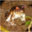

In [5]:
print(f"Image label {labels[int(y_train[0])]}")
Image.fromarray(x_train[0])


# Preprocessing

Convert classes to binary animal or not

In [6]:
y_train = ((y_train >= 2) & (y_train < 8)).astype(int)
y_test = ((y_test >= 2) & (y_test < 8)).astype(int)

### Pieplot target distribution

In [7]:
fig = go.Figure(data=[go.Pie(labels=["Animal", "Not animal"],
                             values=[np.mean(y_train), 1 - np.mean(y_train)],
                             hoverinfo="label+percent",  # Mostra etichetta, percentuale e valore
                             textinfo='percent',  # Mostra solo la percentuale sulle fette
                             
                             pull=[0, 0.01],  # Evidenzia la seconda fetta
                             marker=dict(colors=['#FF0000', '#408040']),  # Colori personalizzati
                             textfont=dict(size=18)
                             )])

# Imposta il layout
fig.update_layout(
    paper_bgcolor = "rgba(0,0,0,0)", 
    plot_bgcolor = "rgba(0,0,0,0)",
    title={
        'text': "Target distribution",  
        'font': {'color': 'white'} 
    },
    font=dict(
        color='white', 
        size=18
    ),  
    legend=dict(
        font=dict(color='white')
    )
)

# Mostra il grafico
fig.show()

Distribution is fairly balanced

### Data augmentation

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    rescale = 1/255.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,   
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale = 1/255.,
)

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=.2,shuffle=True,random_state=0,stratify=y_train)

In [20]:
train_generator = train_datagen.flow(x_train, y_train, batch_size=32,shuffle=True,seed=0)
val_generator = val_datagen.flow(x_val, y_val, batch_size=32,shuffle=False,seed=0)

# Model

## Transfer Learning

Use pre-trained vgg16 model freezing its conv layers

In [12]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3),name="vgg16_mod")
for layer in vgg16.layers:
    layer.trainable = False
vgg16 = Model(inputs=vgg16.inputs, outputs=vgg16.layers[-2].output)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

add dense layers by yourself

In [13]:
w_init = RandomNormal(stddev=0.01)
x = vgg16.output
x = Flatten() (x)
x = Dropout(0.2) (x)
x = Dense(1024, activation='relu') (x)
x = Dropout(0.2) (x)
x = Dense(1, activation='softmax') (x)

In [14]:
model = Model(inputs=vgg16.input, outputs=x)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,813,889 (64.14 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Training

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy', Precision()])
n_epochs = 2
histm = model.fit(train_generator,
              validation_data=val_generator,
              epochs=n_epochs, 
              initial_epoch=0, 
              verbose=1)

Epoch 1/2
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 186s 148ms/step - accuracy: 0.5981 - loss: 0.3861 - precision_2: 0.5981 - val_accuracy: 0.6000 - val_loss: 0.3022 - val_precision_2: 0.6000
Epoch 2/2
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 200s 160ms/step - accuracy: 0.6018 - loss: 0.3719 - precision_2: 0.6018 - val_accuracy: 0.6000 - val_loss: 0.2846 - val_precision_2: 0.6000


In [141]:
histm.history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])

# Results

Let's send output on brower avoiding visualization issues on VSC

In [146]:
import plotly.io as pio

pio.renderers.default = 'browser'

fig.show()

In [147]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure()
epochs = np.arange(1,n_epochs+1)
fig.add_trace(go.Scatter(x=epochs, y=histm.history["loss"], mode='lines', name='Loss', visible=True))
fig.add_trace(go.Scatter(x=epochs, y=histm.history["accuracy"], mode='lines', name='Accuracy', visible=False))
fig.add_trace(go.Scatter(x=epochs, y=histm.history["val_loss"], mode='lines', name='Val Loss', visible=False))
fig.add_trace(go.Scatter(x=epochs, y=histm.history["val_accuracy"], mode='lines', name='Val Accuracy', visible=False))

fig.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(label="Loss",
                     method="update",
                     args=[{"visible": [True, False, False, False]},
                           {"title": "Training Loss"}]),
                dict(label="Accuracy",
                     method="update",
                     args=[{"visible": [False, True, False, False]},
                           {"title": "Training Accuracy"}]),
                dict(label="Val Loss",
                     method="update",
                     args=[{"visible": [False, False, True, False]},
                           {"title": "Validation Loss"}]),
                dict(label="Val Accuracy",
                     method="update",
                     args=[{"visible": [False, False, False, True]},
                           {"title": "Validation Accuracy"}])
            ]),
            direction="down",  # Direzione del menu
            showactive=True  # Mostra il pulsante selezionato
        )
    ]
)

# Aggiungi titolo e etichette agli assi
fig.update_layout(
    title="Metriche di Addestramento del Modello",
    xaxis_title="Epoche",
    yaxis_title="Valore",
    template="plotly_dark"  # Tema grafico
)

# Mostra il grafico
fig.show()
